<a href="_index.ipynb">&larr; LAB </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>

<b>Name, Vorname:</b> 
# LAB 3: Filterentwurf mit pyfda
In diesem Versuch 
### Inhalt
[0. Allgemeine Hinweise](#allgemeines)

[1. Überblick über pyfda](#ueberblick)

[2. Filterentwurf](#entwurf)

[3. Filterexport und -simulation](#export)

## 0. Allgemeine Hinweise<a id='allgemeines'></a>

## 0.1 Jupyter Notebook
* \<SHIFT\>-\<RETURN\> führt eine Codezelle aus und rendert eine Textzelle.
* In Markdown sind Leerzeilen wichtig zum Trennen von Abschnitten! 
* Sie können LaTeX-Code zwischen \\$ ... \\$ einschließen.
* Kontexthilfe zu Funktionen etc. bekommen Sie über \<SHIFT\>-\<TAB\>

Abbildungen in diesem Notebook wurden konvertiert mit https://www.base64-image.de/ und in den HTML-Code eingebettet.

## 0.2 Installation von pyfda
Für diesen Versuch benötigen Sie die Software **pyfda** (Python Filter Design and Analysis), die Sie per `pip install pyfda` installieren können (wenn Sie eine Python-Installation auf Ihrem Rechner haben), alternativ gibt es unter https://github.com/chipmuenk/pyfda Binaries für Windows und für Ubuntu 20.10 (funktioniert vermutlich auch mit anderen halbwegs aktuellen Distros).

## 0.3 Abgabe
Nach dem Praktikumsversuch exportieren Sie das Notebook mit Textantworten, Codezellen und Plots als HTML (File -> Export Notebook As ... -> Export Notebook to HTML) und reichen es in Moodle ein.</div><br />

***

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp
dsp.versions() # print versions 
    
%matplotlib inline
import matplotlib.pyplot as plt
size = {"figsize":(12,5)} # Plotgröße in Inch

import numpy as np
import scipy.signal as sig
import wave

from IPython.display import Audio, display
#-----------------------------------------------------------------------------
def wav2np(filename):
    """ Read the wav-file and convert it to a one or two-dimensional numpy array,
        depending on the number of channels. 
        Properties of the WAV-file are stored as function attributes (evil)
    """
    wf = wave.open(filename,'rb')
    wav2np.N_CH = wf.getnchannels() # number of channels
    wav2np.W    = wf.getsampwidth() # wordlength per sample in bytes
    wav2np.N_FR = wf.getnframes()   # number of frames
    wav2np.f_S  = wf.getframerate() # sample (frame) rate 
    
    print("{0} channels with {1} frames of {2} bytes and f_S = {3} Hz.".format(wav2np.N_CH, wav2np.N_FR, wav2np.W, wav2np.f_S))
    
    if wav2np.W == 2:
        samples_in = np.frombuffer(wf.readframes(-1), dtype=np.int16) # read wav data as 16 bit integers, R and L samples are interleaved
    elif wav2np.W == 1:
        samples_in = np.frombuffer(wf.readframes(-1), dtype=np.int8) # read wav data as 8 bit integers, R and L samples are interleaved
    else:
         raise TypeError("Unknown data format: {0} bytes".format(wav2np.W))   

    samples = np.array([samples_in[idx::wav2np.N_CH] for idx in range(wav2np.N_CH)], dtype=np.int32) # deinterleave channels to numpy array N_CHAN x N_FRAMES
    return samples


Python version: 3.7.4
Numpy: 1.19.2
Scipy: 1.5.2
Matplotlib: 3.2.2 module://ipykernel.pylab.backend_inline


## 1. Überblick über pyfda<a id='ueberblick'></a>

<img src='../00_LAB/pyfda.png' align='center' width='80%'></img>

Auf der linken Seite wählen und entwerfen Sie Filter unter den Tabs "Specs" (Filterentwurf), "b,a" (Eingabe von Filterkoeffizienten), "P/Z" (Eingabe von Polen und Nullstellen). Auf der rechten Seite schauen Sie sich Betrags- und Phasengang, Gruppenlaufzeit, P/N Diagramm und die transiente Antwort auf verschiedene Stimuli an.

### 1.1. Frequenzen und Amplituden
Frequenzen können in unterschiedlicher Form eingeben und angezeigt werden:

* Normalisiert auf die Samplingfrequenz $f_S$: $F = f/f_S$ 
* Normalisiert auf die Nyquistfrequenz  $f_{Ny} = f_S/2$: $F = 2f/f_S$
* In absoluten Frequenzen, hier können Sie die Abtastfrequenz $f_S$ eingeben. In der Einstellung "Lock" (verriegeltes Schloss) bleiben die absoluten Frequenzen gleich wenn die Abtastrate geändert wird. Bei "Unlocked" werden die absoluten Frequenzen so angepasst, dass die normalisierten Frequenzen gleich bleiben und damit auch Filterentwürfe, Signalverläufe etc.

Amplituden werden in V, W oder dB eingegeben und angezeigt.

### 1.2 Filterspezifikationen
Filterentwurfsalgorithmen benötigen unterschiedliche Eingabeparameter. Wenn "Order Minimum" angeklickt ist, versucht ein Algorithmus die minimale Ordnung zu den gegebenen Filterspezifikationen zu berechnen, halbwegs genau funktioniert das aber nur bei Equiripple (FIR) und den meisten IIR-Filtern. Bei pyfda können  Sie nach dem Entwurf mit minimaler Ordung das Häkchen entfernen und dann selber Entwurfsparameter bearbeiten.

Nicht benötigte Parameter sind entweder deaktiviert oder ausgeblendet. Manche Parameter sind ausgegraut, aber bearbeitbar: Diese Parameter beeinflussen nicht den Filterentwurf, sie dienen aber z.B. dazu um das Toleranzschema anzuzeigen.

## 2. Filterentwurf<a id='entwurf'></a>
Ein Audiotrack von einer CD ($f_S = 44,1 \,\text{kHz}$) soll tiefpassgefiltert werden. Die Filterspezifikationen sind:

* Eckfrequenz des Passbands: $f_{PB} = 3,4\, \text{kHz}$
* Eckfrequenz des Sperrbands: $f_{SB} = 4\, \text{kHz}$
* Max. Ripple im Passband: $A_{PB} = 1\, \text{dB}$
* Min. Dämpfung im Sperrband: $A_{SB} = 60\, \text{dB}$

Es sollen die folgenden Filtertypen getestet werden:

* Fourier-Approximation / Least-Square (Windowed FIR mit Boxcar-Fenster)
* Windowed FIR mit Kaiser-Fenster
* Equiripple
* Butterworth
* Chebychev 1
* Chebychev 2
* Elliptisch (Cauer)

### 2.1 Filtervergleich

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

Ermitteln Sie die folgenden Filtereigenschaften und fassen Sie sie in einer Tabelle zusammen mit den Spalten:

<b> Filtertyp | IIR/FIR? | Ordnung <i>N</i> | Gruppenlaufzeit &tau;<sub>g</sub> | Mult. *L* pro Sample | Max. Samplerate | Vor-/Nachteile</b>

* Welche der Filter sind **FIR**, welche **IIR**?

* Vergleichen Sie die benötigte **Ordnung** ***N***. Für nicht alle der Filter gibt es gut funktionierende Designalgorithmen, Sie müssen dann von Hand die Filterordnung und / oder Eckfrequenzen so lange anpassen, bis alle Spezifikationen erfüllt sind. Im Tab "Info" sehen Sie, ob Spezifikationen verletzt werden. Welche Ordnung benötigen Sie, wenn Sie die Abtastrate vor der Filterung auf die Hälfte reduzieren? (Tipp: Aktivieren Sie das "Schloss" neben der Samplingfrequenz, bevor Sie f_S ändern.)

* Welche **Gruppenlaufzeit &tau;<sub>g</sub>** haben die Filter bei $f = 2 \,\text{kHz}$? Schauen Sie sich im `y[n]` an, wie die Signalform eines 500 Hz Sägezahnsignals durch das Filter verformt wird.

* Wieviele **Multiplikationen** ***L*** **pro Sample** werden benötigt? Berücksichtigen Sie dabei die Filterstruktur (Optimierung durch Linearphasigkeit möglich?), IIR Filter sollen in einer kaskadierten SOS-Struktur realisiert werden - siehe folgende Abbildungen.

* Welche **maximale Samplerate** kann man auf einem DSP mit max. $300 \cdot 10^6$ Multiplikationen / s verarbeiten?
  Zusätzliche Informationen: [How fast are DSPs?](https://www.dspguide.com/ch28/6.htm)
  
* Fügen Sie den **Plot des Betragsgangs** mit Phasengang (Checkbox "Phase") ein.


<table><tr><td><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAU4AAACSCAMAAAAdBtO7AAAACXBIWXMAAC7hAAAu5wGLE5KDAAABm1BMVEUAAAAAADoAAGYAOjoAOmYAOpAAZpAAZrYBAQECAgIDAwMEBAQFBQUGBgYHBwcICAgJCQkLCwsNDQ0QEBASEhITExMUFBQYGBgZGRkgICAkJCQmJiYoKCgwMDA2NjY3Nzc4ODg6AAA6ADo6AGY6OmY6ZpA6kLY6kNs9PT0/Pz9AQEBGRkZHR0dISEhPT09QUFBSUlJTU1NXV1dYWFhZWVldXV1fX19gYGBjY2NmAABmAGZmOgBmOjpmOpBmZmZmkLZmkNtmtttmtv9nZ2doaGhtbW1vb29wcHBxcXFycnJ3d3d4eHh/f3+Dg4OHh4eMjIyNjY2Pj4+QOgCQOmaQZgCQZjqQkJCQttuQtv+Q27aQ2/+VlZWXl5eampqbm5ufn5+jo6Onp6eoqKivr6+1tbW2ZgC2Zjq2kDq2tma2tv+227a22/+2/7a2//+3t7e8kDq/v7/Dw8PHx8fPz8/R0dHX19fbkDrbkGbbtmbbtpDb25Db29vb/7bb///f39/g4ODn5+fv7+/39/f/tmb/25D/27b//7b//9v///+HkaCvAAAPWElEQVR42u2d/WPbRhnHL+26NG1abRgmDDZzeAsTGMPMcMMGo8EQmDWDy9soZsZ10wJjQbVjDxhVJTlL9Geje9GL9ZZ7k11vvh+StLa+evTRc8/dPXc6AXdTJBawQbDBuTY4z/bAtafk74t7YOv+BpEYzsPIv+Y0OC0jr5jUpuTrMAgVpLcknAOQV3RqU/J1GIQK0qPHOYMV/PjKhz7O+ZV/vAle+IAWp6ZnlQYTzmwdJqGC9Ohxnh8cujOEDuOcbX3j6cXvtmlx6lyfMX13wINTrh5DZT++9t+9/aCyX9xD3nrt6QYnH06vQd8OYyd0Vo/pxjt5cV7cg4HTx4konnnuusHJh3Pm9zARTtQyQZQMOOdhmxl0XPlwpioJ4JSlR49zDvaPw8oOqzlmyoBzFhq9LeadqUoCOGXpUeM8PwjCJMQZhE4WnMeh0ftiOFOVBHDK0qPFiQLnxb2gZUcQEVPG2HmcGJTyxs6EkmDslKG3tFGRHozxI2FTBGdSSQynFL1l4wx6W8I4k0piOKXoyc0oWYlj7Zhl84WwmWm1dfnlJ5VShGx6nFR6ReDM+aY2iv1Pq9yzo5bNkvm8FKvHoDXBfz3sZX13RhOEFd+g096zhQ+mTYNHb8k4ASj3Ib4nNwB4F+EEoHRkBpZ5zkzGArlWG54QBPHw9s7NnXdTv5uilCKEDHJc943rN3f+GjtDdcCut3ScGN8t7/fuQ4zTK413iGXnB4mWKAsnAJXB9Ze9XzvP0r6bopSOEwBV//XNmA4+g9r9M6OedJwtwFd0P+zuM+YcM1KQKUrZQjvXZepVl+qdsJrCX7t3AvrlH4Sjj0OX1jtBA0Avv36a9t0UpSzvBNXv7cZ0/DMARj1GHuI4ldbU++PVXbDzeZvg9PCGow8/3j8C4Op7eTiVtun2buxcv34nfziQK4RuitfovHoD7LyRuGGq/oeU4UUguHqcqk66OHfAd1AnpaWgNppYFsb7+ZX77mP8dypOtYsOt3vgNGs4gI/OF0I3BZb3wcP4DasMnBS9iODKcRqJg6ZWuuPMwN2cOuUMM06e/G6+0ImdcRHJjlJScOU4Mw9KWOZF/qt3aRrQy3DSCgHalGYouEY43U/e8mO/GE5aIWqcoeA64YRusC0DJ6UQPc5AcH1wzrcO3bMDCd5JLUSLMyK4PjgvHu+BrZ9KiJ3UQrQ4I4LrVdnpxnL0OvIq+/q17BucG5wbnJ9WnK3MVX8dJpzZOvlCWTg59JaCc3EGKYGBct1fTIVNJ08oC+flepeYVBDO2BTc4kETPa8YmSpsOnlC6RdBo3eJSQXhnC0msznPOYunxHltjwvxM5BmEtPhxy8+Alt3Rc8ZU+G3PS7Ez0CaSSyHnx94p8TLadth8BkzniqiImZ7QoibgTSTmA6HaxO9U8P5Flv1abZZTxVRcQ0NFgB/dFwBIase6DQcV0TJdbswogIUV51CcaKATRYxDQlN1WY9VVTFrfl3RZm4IkKdoLL0Oa5+wSQ9kDoq1jtRwPZvYh2fcsgX9n2ViUJMZ3fOBSGnTHRq3C2Rb5JT8T3FKRYnWvt59tX7F/fAtmshEA2OsE9UvKs4DNyq7HAL/ekATgGdcDt5/MKCGdBRsbETLv/ETx7su8eHbg9ab3GEfaLiHsOEOHGrE5db6F+H7szzqyavky9e2KP7wTqMgpuis72rf3T/7YWZj+673ondKgA9nrBPVM7/Dr0T+0LLFRDyYp8nZMHGscJVPyNKF7/9kEgpZsE451f++SZ4wTvpI4xzwrVWIlDBlR35gmoJCZ3/+CkZTBpcFx9ROtj2x6XdpaVAiHe6YOIKFYzT84WBkMz5j/Dsucbl5HG0+7idrTpLw4ljp/hT2zN//kdI5exrZFXcFFjiBmGcJvPgRAAnbgCl4RTUOQ6eHRB+KD9c7L36fOeST16gzgbnBucG5wbnBudnCmdf07RbmtYU1RljHU3C1h4SpNjJkIRnV9R20VwYKU5Jxpp2LIUvrbJU7zzCHCaixlflyBB7ejJqeldYih2niR85ELZ9KJq9IcUSTFFGpWDuseQsFafbEMwJRqvWiQQIDd78XLK0RcMPB86JpFDVlSMDo7BiycEJL81aMk7OfGda1RpIgVCVkVHCpS4YfnhwjiSFqrYcGS8KT2ThHC0zo4SLbbzyuiFuuWP85leGLa5jG3/5uSELp/nLnjFZIk67T+b7agMR13IGZGa40hciKskcwrJD+tTNkyXh7HtdiWpT1+veVZT4W3fD63tX6rre9KAqAnFYkjn4DsM5PK2tdzQPamW6BJyO15FokxONm/zdEx2AOolRptcLb3I6qNOSYw42pArULmnVhzXem8OEswXUSKQeKJx9NB0okSUbY5V3TNAAqiHBHBw1ykCzF264UTTOPlAXsgPTEldv/iS2xsCu8D2q3wXlhT7iVBUYXMR7SPFrlY9zqpA7NvGXro54+s92iXQ3AxlPmKM1nQBlHDenxNsH74GyvSjW4lqmw4DzyHeicJl+m8Oven6nO5TpAY48XctPaoU6Le7hRdnvbwZiTpnnHtPjdEq+K4b2W0Cld0ryOHzFNzOUCaVpxkBojwLXVvxcRagzoTcHn7dn+fGn7rLfY7s+5Mc5CoZykYdI6tSjCJNs1jAJGp6ITJthOWHZ6xacwKFQW8QcYpPSMvH5h27KPUa/T187zb4ktFUOF85eUJMi9h9RD7txXq9ujIL2NyIzYOjklPFGN3pw5oXbMmTDSfa/0ICZFKvAbMgTuHGLYmcfXupYXDjbqN2cGIbxDvghfDRnihh3mHAC8EV0V6ahzARVtiYbTu8SUbsYMcdEjX2XGSfcdElFGIxQzHaDhayXl5bFgbOF7NciKi7rxj64DNyFLYZg3Td4thuaLJqjo+4NV1FvlxCLsMBLbcKfjRvwn09yPYQLJ65dA13XvwtegwvIR+g/eyyeUBuS2jQKZQZuNBDSeWe5Zx+hyhIxBxLosC3pNslw360C6I56KAZdvQa8+vdwB24r9Ex+ZR8G9ToSX1rU+XQTRyl3HNTriAxLJS2jHdHSQ3mLLb0PeTTHaHw1SYqVAWxmvrWLN42S3RRNg9x55JQqdQ/H0XG0txU10cHxHIEeQx/3s8dBNzvSGKtswwoL7gGHb2fSVfxVrA/AgyI6Sl6cMuKnHHEkr1t+kxy1nGMytprsv/Z5c+lWyj1u+u7PMg5n+O7QXzJ9og2CvAF7ZnDsrzkOZLwbxTGa6YFa0hzeXHrD774FYkYwpVkQTqcWn5NpBIMJNtO1eCPHs7TdqcQzSE3+iZ6pEkufWGpwiwvCCU8RvQDnyM8bMHNoRvF1FYUrWWuWFhowXnOC9Em0ok0j03npiNK34WXKdxolUAuufFwBKt+0ylQFlSCbaNaBMuRDcCLHnCDD2QnuxqDkR5IcnGmbRLNNbphVb5w4MsypMax5HXDedJhdh0MRY2oao4Y3YOSmMJVjDvHPEii1vfHQ2OiVFxYvFIfTdbr+Q3ug0hewfVAJRiS6wNyb01WlmINjWdt/sBHlWFJxoqcO0RsK0l/sxD4xPOx8CWh1XXQ5jKFrX35F6wxFIQw72ldufVuXsTrHtfttTdOaXTOzeZnD3SrJG17SXuzEMc/uqEDOGpYqmErROQJ9t8ASRQQfKcWvJEl/sRMHzpGkFVYjCas78ThLzlonGpzw1RnIQzNe7AR4nErOoppGZiKRtT8vZyUeDc6Le/uRl5MkX+zEjnPM+yx+rExkrXJV5awTpeuaH+9j58x4sRPgcSopKwlRylOVEjO8Ml0SztmLZG+G9Bc7MeMkOVPh2oV3GZCw7LYmZ409Jc45iLzFLfliJ2acZGm8cO3qCOw5kYgZkqIwBc6zvf2wG598sRMzzqlh3AKGIbyiEs4WeTpjUR0b6xjOkiq7//IOKaMiXE8/xY9pXaL+ycGhKxun+1nFeX7g7x0sJaP0WcdZkCUbnBucG5wbnBucG5yrxelIMt/a4IRFl/SUWQPIGRn2gbHGOKeK+EgblhHHlqqpTl7i3ILu+cCpycl3ogewxxIut7m4C/qa4URLOkvis0UoNVUVdyu0gacyXVOcFp6KFd4SZSJnSxF/H1BtTXG2xLdgRaVK8pRTGU5O1jSvB86P9sK91YNl1zyzbxGhXnQtt4DOJLDHWhOcxy984P6HZPeC7ZZ5phMiQpaysFSeW8d3cs6NaleAk0wo45y+jV6nAtBPVrOiQmaoMxHREbFnVZX94uOP/7aQe148yDLyipkjVIwOnZ5hrso7t77+k98vvDmF7wU7SaFidOj06LuqknCe7QFw7SmuVbMrH/pby6Zg0DLfYtNAViOl//lC5wf+5KqYzmW71ObpEcHleyfaNx8ubSJ7q6dhoHo5WSA0w/u9C+vg/efzcPK+7KxAnOcH33x68Qg5JtpbnRtDRAjt9y6sQ/afXy+csIZtvQ1fRkD2VufFEAqR/d7FddYRZ6TM9/NwzsMwH0yZplrt7/cuqkOJM01v9TiDvdWzMMxCs7fzrA72exfUocWZprd6nOHe6hkYjkOz9/OsztrvnVWHFmea3nNR2d1LY+cxWHy1H+9rR0V0aPTWA2fEg4VwCunQ6K0HTq/R3XYl4BTSodFbD5zzaHgSwCmkQ6O3Hjhn2SHKsaToGIN8e0w6vfDD6fOL0wtR/mrS2GeWXkrkI2sAvGIz6TiDakq6uQfATbJZx0m45Uy+ni/YK2vPL87zg/SIP20pyfRuTQVA/QKDjqWradn7093b4OXbCDbMbZtUeliwU6KZDSgeZ0auy4v4KSHKqKdmy9F/7jxJw5mm84uWkj4ZcmcXbn7yxNbxnKBJped9+LMW5eRK4Th7Gd7pjT8OmXKOGbclTef75GHWm1L0WAwrFY0zq5EMOsuPALj6HvnMIU8Hx73zpTIAn9t9Rq3jDqqp3vTgJtqaZ0q818zTiwq+rhUwoywTZxDx51fuu4/Rn/izEy0F5xPlJWX3AZOO0Ui7/NcU5da7uLlLxxm2RIuCk+ZzjTMcS4O7sc8mreRMo93rnbLqmO2U9RLv9x6Szli/nOqdmYLmUWkNcHqh/+rd2GeWKUfnkjLO7aknBe3J84/T/eQtEvwZBh/SdPIGPkKCK8MJ/WBbAk4unfxxpIDginDOtw7dswNx7+TUycYpKLginBeP9wB5PEwIJ6dONk5BwRVWdvbEjTQdqmM2ODc4Nzg3OFeOs5W5TK3DhFOODo0el+CycEpZqCZNhzJpVAjO/wNo98TVEq5hoAAAAABJRU5ErkJggg=="/></td><td>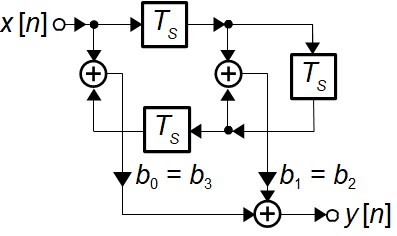</td>
<td>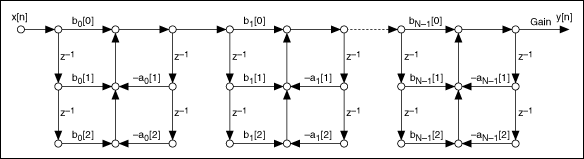</td>   
   </td> </tr><tr><td> Direktform</td><td>Lin. phasige Form</td><td>Kaskadierte Second Order Sections</td> </tr></table>

### 3. Filterexport und -simulation<a id='export'></a>
Im folgenden sollen Sie Audiofiles mit dem Equiripple und dem elliptischen Filter filtern. Dazu können Sie aus pyfda Filter in verschiedenen Formaten exportieren:

* Im Tab **Specs** speichern Sie Filter *komplett* ab, um sie später wieder in pyfda zu laden
* Im Tab **b,a** exportieren Sie die *Filterkoeffizienten*, u.a. im CSV (Comma Separated Values) Format. Sie können mit dem "Zahnrad" einstellen, dass die Koeffizienten direkt zum Clipboard (Zwischenablage) exportiert werden. Von dort können Sie sie einfach als Python Listen oder Arrays (`a = [...]`) in die nächste Codezelle einfügen.
* Im Tab **P / Z** exportieren Sie die *Pole und Nullstellen*, auch hier können Sie über die Zwischenablage gehen.

Sie können Daten im Zeitbereich filtern mit 

`y = sig.lfilter(b,a,x)` 

`b` und `a` sind die Koeffizientenvektoren (nicht-rekursiver / rekursiver Teil), `x` ist das Eingangssignal. `y` hat die gleichen Dimensionen wie `x` (es können auch Stereofiles verarbeitet werden). Was müssen Sie bei einem FIR-Filter für `a` angeben?

Wenn die Filterbeschreibung als Second-Order Sections vorliegt, kann auch der folgende Befehl benutzt werden (allerdings unterstützt pyfda noch keinen Export im sos - Format):

`y = sig.sosfilt(sos,x)`

Anhören können Sie sich die gefilterten Audiofiles wieder mit `display(Audio(data=y, rate=wav2np.f_S))`.

Sie können auch eigene WAV-Files in Ihr `medien` Verzeichnis hochladen und testen, bei großen Audiofiles sollten Sie zunächst nur ein paar Sekunden testhören (mit `x[:N_samples]` bzw. `x[:, :N_samples])` bei Stereo-Samples. Was bewirkt die seltsame Syntax bei Stereosignalen?

Hören Sie einen Unterschied zwischen dem Orginal und den beiden unterschiedlichen Filtern? Woran liegt das?


In [10]:
x = wav2np("../medien/87778__marcgascon7__vocals.wav")
b_FIR = []
a = 1
y_FIR = sig.lfilter()

print(np.shape(y_FIR))

#y_IIR = sig.lfilter(b_IIR, a_IIR, x_w)
display(Audio(data=y_FIR, rate=wav2np.f_S))
print(y_FIR.dtype)


2 channels with 349952 frames of 2 bytes and f_S = 44100 Hz.
(2, 20000)


float64


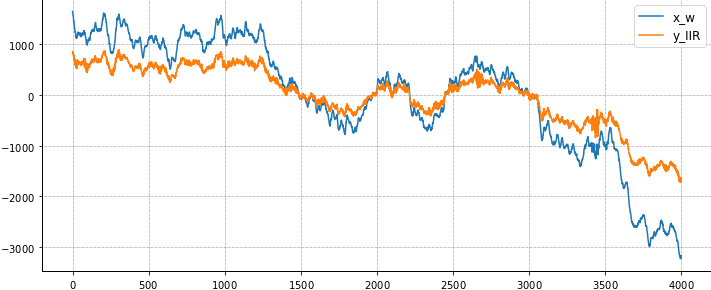

In [7]:
fig, ax = plt.subplots(**size)
l = 4000
start = 20000
ax.plot(np.arange(l), x_w[0][start:start+l], label="x_w")
ax.plot(np.arange(l), y_IIR[0][start:start+l], label="y_IIR")
ax.legend();

***
### Copyright

(c) 2016 - 2020 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.